# GHG HLM on Scope 3 source Investments

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import warnings
from statsmodels.regression.mixed_linear_model import MixedLM


#read in dataset from GHG_post_outliers data set
investments=pd.read_csv('/Users/amberjensen/Desktop/GHG_Emissions_Project/investments.csv')

In [2]:
#check for info
investments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                905 non-null    object 
 1   account_id                  905 non-null    int64  
 2   Year                        905 non-null    int64  
 3   incorporated_country        905 non-null    object 
 4   Primary activity            905 non-null    object 
 5   Primary sector              905 non-null    object 
 6   Market_Cap_USD              810 non-null    float64
 7   Third_party_verification    904 non-null    object 
 8   Revenue_USD                 824 non-null    float64
 9   ebitda_USD                  824 non-null    float64
 10  grossProfit_USD             824 non-null    float64
 11  netIncome_USD               824 non-null    float64
 12  cashAndCashEquivalents_USD  824 non-null    float64
 13  shortTermInvestments_USD    824 non

In [3]:
#show a df for investments
investments.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,Aptiv,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,No third-party verification or assurance,1.443500e+10,2.260000e+09,...,9.900000e+07,1.248000e+10,8.810000e+09,1.710000e+08,4.344000e+09,3.670000e+09,Investments,3835.0,380471.81,4072324
1,Associated British Foods,1085,2018,United Kingdom,Apparel stores,Discretionary retail,2.051429e+10,Third-party verification or assurance process ...,1.977898e+10,2.363470e+09,...,3.429000e+08,1.738884e+10,5.582920e+09,3.810000e+08,9.880600e+08,1.180592e+10,Investments,73157.0,2801746.25,4072324
2,GlaxoSmithKline,7374,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.508927e+10,Third-party verification or assurance process ...,3.914267e+10,9.344660e+09,...,1.871980e+09,7.374382e+10,6.908038e+10,1.978660e+09,3.310128e+10,4.663440e+09,Investments,14864.0,1227269.00,4072324
3,Kingfisher,10156,2018,United Kingdom,Specialist retail,Discretionary retail,5.248698e+09,Third-party verification or assurance process ...,1.483995e+10,1.195070e+09,...,1.905000e+07,1.504696e+10,7.237730e+09,1.905000e+07,3.512820e+09,7.809230e+09,Investments,10321.0,234624.50,4072324
4,Lloyds Banking Group,10781,2018,United Kingdom,Banks,Financial services,5.110653e+10,Third-party verification or assurance process ...,2.357882e+10,1.424940e+10,...,2.694648e+11,1.012949e+12,9.491967e+11,2.176678e+11,1.396086e+11,6.375273e+10,Investments,19248.0,130601.75,4072324


In [4]:
#define a list of numeric columns
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_amount', 'scope_1_2_emissions_amount']

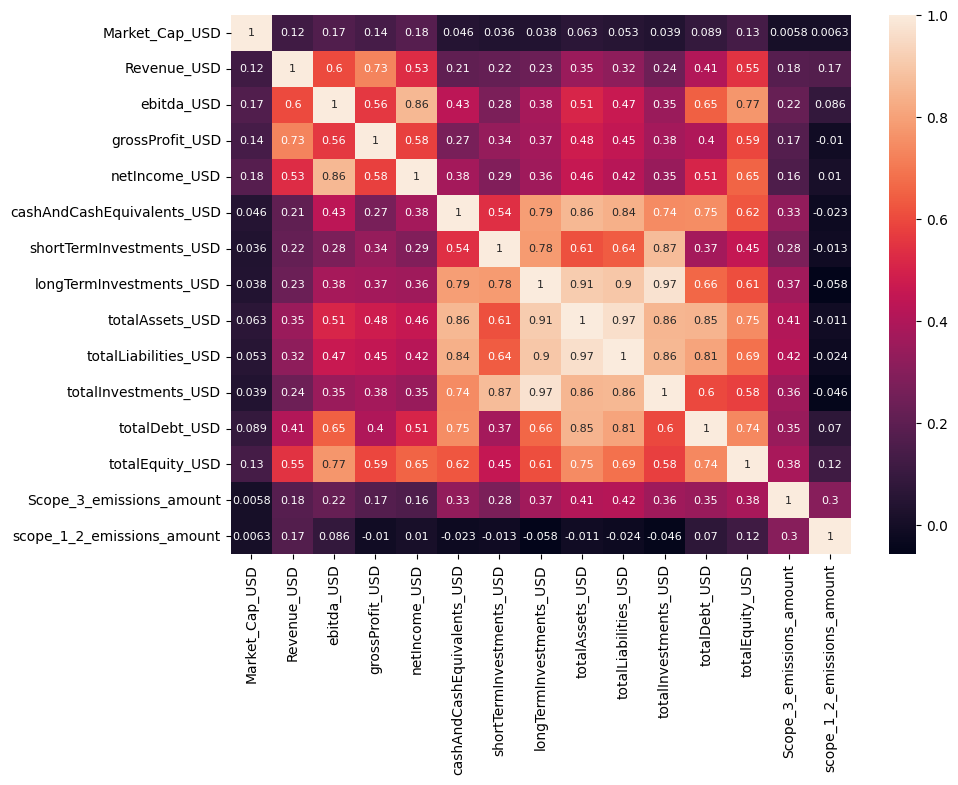

In [5]:
#plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(investments[numeric_cols].corr(), annot=True, annot_kws={"size": 8})
plt.show()

In [6]:
#correlation matrix
investments[numeric_cols].corr()

,Market_Cap_USD,Revenue_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount
Market_Cap_USD,1.000000,0.123163,0.168321,0.140534,0.179846,0.045934,0.036170,0.037818,0.062922,0.053015,0.038581,0.088885,0.133900,0.005813,0.006321
Revenue_USD,0.123163,1.000000,0.601228,0.729305,0.529290,0.206235,0.218751,0.233902,0.349697,0.322147,0.235880,0.407353,0.546538,0.181159,0.173647
ebitda_USD,0.168321,0.601228,1.000000,0.561111,0.856332,0.433292,0.275055,0.376464,0.512444,0.466042,0.348427,0.647318,0.772683,0.222054,0.085942
grossProfit_USD,0.140534,0.729305,0.561111,1.000000,0.579217,0.265050,0.338583,0.370151,0.476625,0.449700,0.376009,0.399943,0.591221,0.174842,-0.010208
netIncome_USD,0.179846,0.529290,0.856332,0.579217,1.000000,0.375087,0.287614,0.360913,0.457288,0.420058,0.346954,0.506669,0.653607,0.160348,0.009997
cashAndCashEquivalents_USD,0.045934,0.206235,0.433292,0.265050,0.375087,1.000000,0.538763,0.792556,0.855720,0.838754,0.744793,0.748199,0.624598,0.330399,-0.022637
shortTermInvestments_USD,0.036170,0.218751,0.275055,0.338583,0.287614,0.538763,1.000000,0.781962,0.613278,0.639990,0.869656,0.372363,0.452721,0.275807,-0.012739
longTermInvestments_USD,0.037818,0.233902,0.376464,0.370151,0.360913,0.792556,0.781962,1.000000,0.910214,0.898700,0.971928,0.663536,0.611255,0.366511,-0.057681
totalAssets_USD,0.062922,0.349697,0.512444,0.476625,0.457288,0.855720,0.613278,0.910214,1.000000,0.965134,0.855066,0.849186,0.747215,0.407370,-0.011087
totalLiabilities_USD,0.053015,0.322147,0.466042,0.449700,0.420058,0.838754,0.639990,0.898700,0.965134,1.000000,0.856057,0.806406,0.685774,0.416238,-0.024407


In [7]:
#drop columns due to collinearity, keeping total
investments=investments.drop(columns=['longTermInvestments_USD', 'totalLiabilities_USD', 'cashAndCashEquivalents_USD', 'totalInvestments_USD', 'totalDebt_USD',
                                      'netIncome_USD', 'shortTermInvestments_USD', "account_name", "Third_party_verification", "Scope_3_emissions_type"])

In [8]:
investments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  905 non-null    int64  
 1   Year                        905 non-null    int64  
 2   incorporated_country        905 non-null    object 
 3   Primary activity            905 non-null    object 
 4   Primary sector              905 non-null    object 
 5   Market_Cap_USD              810 non-null    float64
 6   Revenue_USD                 824 non-null    float64
 7   ebitda_USD                  824 non-null    float64
 8   grossProfit_USD             824 non-null    float64
 9   totalAssets_USD             824 non-null    float64
 10  totalEquity_USD             824 non-null    float64
 11  Scope_3_emissions_amount    905 non-null    float64
 12  scope_1_2_emissions_amount  904 non-null    float64
 13  Year_sq                     905 non

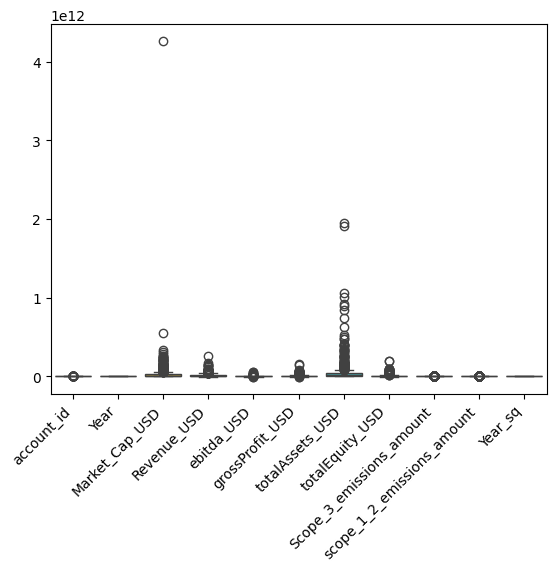

In [9]:
sns.boxplot(investments)
plt.xticks(rotation=45, ha='right')
plt.show()

<Axes: xlabel='Year', ylabel='Market_Cap_USD'>

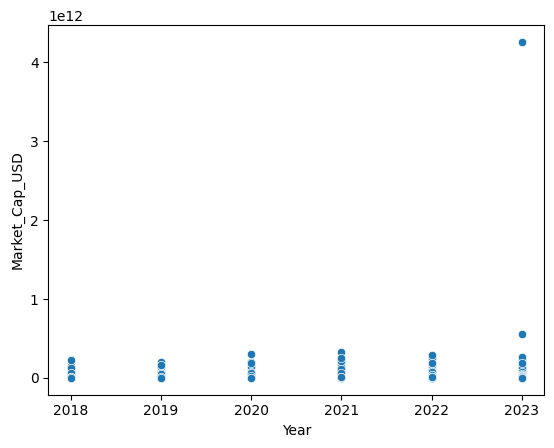

In [10]:
#plot a scatter plot of scope year emissions and scope 1_2 emissions

sns.scatterplot(x='Year', y='Market_Cap_USD', data=investments)

In [11]:
investments_sorted=investments.sort_values(by='Market_Cap_USD', ascending=False).reset_index(drop=True)

#display sorted df
investments_sorted.head()

,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Revenue_USD,ebitda_USD,grossProfit_USD,totalAssets_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,21889,2023,Chile,Pulp & paper mills,Wood & paper materials,4.259662e+12,8.099816e+09,9.337530e+08,1.754288e+09,1.717731e+10,7.884897e+09,5368.0,1968684.0,4092529
1,5377,2023,USA,Pharmaceuticals,Biotech & pharma,5.534120e+11,3.412410e+10,1.245550e+10,2.754810e+10,6.400630e+10,1.086370e+10,10.0,545000.0,4092529
2,14683,2021,USA,Pharmaceuticals,Biotech & pharma,3.316838e+11,8.128800e+10,2.853300e+10,5.046700e+10,1.814770e+11,7.746300e+10,36839.0,1243618.0,4084441
3,20182,2020,Denmark,Other renewable energy equipment,Renewable energy equipment,3.044989e+11,1.600452e+10,1.856520e+09,1.661040e+09,1.961280e+10,5.079240e+09,7000.0,80452.0,4080400
4,14683,2022,USA,Pharmaceuticals,Biotech & pharma,2.877126e+11,1.003300e+11,4.363900e+10,6.598600e+10,1.972060e+11,9.591700e+10,36178.0,1181996.0,4088484


In [12]:
#remove account id=21889

investments=investments[investments['account_id']!=21889]

<Axes: xlabel='Year', ylabel='Market_Cap_USD'>

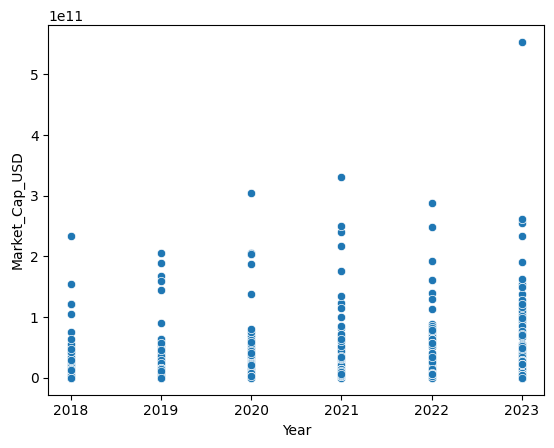

In [13]:
#rerun the plot
sns.scatterplot(x='Year', y='Market_Cap_USD', data=investments)

In [14]:
# copy dataframe
investments_no_transform = investments.copy()
# Change 'incorporated_country' to 'Countries' in investments dataframe
investments_no_transform = investments_no_transform.rename(columns={'incorporated_country': 'Countries',
                                                       'Primary activity': 'Primary_activity',
                                                        'Primary sector': 'Primary_sector'})

print(investments_no_transform.info())
investments_no_transform.head()

<class 'pandas.core.frame.DataFrame'>
Index: 904 entries, 0 to 904
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  904 non-null    int64  
 1   Year                        904 non-null    int64  
 2   Countries                   904 non-null    object 
 3   Primary_activity            904 non-null    object 
 4   Primary_sector              904 non-null    object 
 5   Market_Cap_USD              809 non-null    float64
 6   Revenue_USD                 823 non-null    float64
 7   ebitda_USD                  823 non-null    float64
 8   grossProfit_USD             823 non-null    float64
 9   totalAssets_USD             823 non-null    float64
 10  totalEquity_USD             823 non-null    float64
 11  Scope_3_emissions_amount    904 non-null    float64
 12  scope_1_2_emissions_amount  903 non-null    float64
 13  Year_sq                     904 non-null

,account_id,Year,Countries,Primary_activity,Primary_sector,Market_Cap_USD,Revenue_USD,ebitda_USD,grossProfit_USD,totalAssets_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,1.443500e+10,2.260000e+09,2.729000e+09,1.248000e+10,3.670000e+09,3835.0,380471.81,4072324
1,1085,2018,United Kingdom,Apparel stores,Discretionary retail,2.051429e+10,1.977898e+10,2.363470e+09,4.551680e+09,1.738884e+10,1.180592e+10,73157.0,2801746.25,4072324
2,7374,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.508927e+10,3.914267e+10,9.344660e+09,2.613660e+10,7.374382e+10,4.663440e+09,14864.0,1227269.00,4072324
3,10156,2018,United Kingdom,Specialist retail,Discretionary retail,5.248698e+09,1.483995e+10,1.195070e+09,5.483860e+09,1.504696e+10,7.809230e+09,10321.0,234624.50,4072324
4,10781,2018,United Kingdom,Banks,Financial services,5.110653e+10,2.357882e+10,1.424940e+10,2.357882e+10,1.012949e+12,6.375273e+10,19248.0,130601.75,4072324


In [15]:
investments_no_transform['Primary_sector'].value_counts()

Primary_sector
Chemicals                                             124
Electrical & electronic equipment                      95
Financial services                                     93
Media, telecommunications & data center services       50
Construction                                           48
Food & beverage processing                             43
Biotech & pharma                                       32
Discretionary retail                                   25
Trading, wholesale, distribution, rental & leasing     25
Metal products manufacturing                           25
Thermal power generation                               23
Convenience retail                                     22
Metallic mineral mining                                22
Energy utility networks                                22
Air transport                                          18
Specialized professional services                      18
Oil & gas storage & transportation                     14

In [16]:
investments_no_transform['Primary_activity'].value_counts().head(20)

Primary_activity
Telecommunications services                           50
Banks                                                 42
Other base chemicals                                  39
Electronic components                                 35
Personal care & household products                    32
Specialty chemicals                                   27
Electronic equipment                                  26
Insurance                                             24
Pharmaceuticals                                       23
CCGT generation                                       23
Supermarkets, food & drugstores                       22
Transportation infrastructure & other construction    22
Precious metals & minerals mining                     21
REIT                                                  19
Passenger airlines                                    18
Fabricated metal components                           18
Other professional services                           16
Inorganic base

In [17]:
# Looking at missing data
print(investments_no_transform.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                10.5
Revenue_USD                    9.0
ebitda_USD                     9.0
grossProfit_USD                9.0
totalAssets_USD                9.0
totalEquity_USD                9.0
scope_1_2_emissions_amount     0.1
account_id                     0.0
Year                           0.0
Countries                      0.0
Primary_activity               0.0
Primary_sector                 0.0
Scope_3_emissions_amount       0.0
Year_sq                        0.0
dtype: float64


Apply signed log transformation and split data by company and year into train_df (2018-2022) and test_df (2023):

In [18]:
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'ebitda_USD', 'grossProfit_USD', 'totalAssets_USD',
                'totalEquity_USD', 'Scope_3_emissions_amount', 'scope_1_2_emissions_amount'
]
required_cols = [
    'account_id', 'Year', 'Year_sq', 'Countries', 'Primary_activity', 'Primary_sector'
] + numeric_cols

# --- Prepare Data ---
df = investments_no_transform[required_cols].dropna()

# --- Signed log transform ---
def signed_log(x):
    return np.sign(x) * np.log(np.abs(x) + 1)

for col in numeric_cols:
    df[f'slog_{col}'] = signed_log(df[col])

# --- Company-level split by year ---
train_df = df[df['Year'].between(2018, 2022)].copy()
test_df  = df[df['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

# --- Remove rare categories in Primary_activity and Countries (≤2 rows) to prevent singular matrices ---
for col in ['Primary_activity', 'Countries']:
    value_counts = train_df[col].value_counts()
    allowed = value_counts[value_counts > 2].index
    train_df = train_df[train_df[col].isin(allowed)].copy()
    test_df = test_df[test_df[col].isin(allowed)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (572, 22)
Test shape: (120, 22)


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 572 entries, 0 to 681
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       572 non-null    int64  
 1   Year                             572 non-null    int64  
 2   Year_sq                          572 non-null    int64  
 3   Countries                        572 non-null    object 
 4   Primary_activity                 572 non-null    object 
 5   Primary_sector                   572 non-null    object 
 6   Market_Cap_USD                   572 non-null    float64
 7   Revenue_USD                      572 non-null    float64
 8   ebitda_USD                       572 non-null    float64
 9   grossProfit_USD                  572 non-null    float64
 10  totalAssets_USD                  572 non-null    float64
 11  totalEquity_USD                  572 non-null    float64
 12  Scope_3_emissions_amount   

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 683 to 901
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       120 non-null    int64  
 1   Year                             120 non-null    int64  
 2   Year_sq                          120 non-null    int64  
 3   Countries                        120 non-null    object 
 4   Primary_activity                 120 non-null    object 
 5   Primary_sector                   120 non-null    object 
 6   Market_Cap_USD                   120 non-null    float64
 7   Revenue_USD                      120 non-null    float64
 8   ebitda_USD                       120 non-null    float64
 9   grossProfit_USD                  120 non-null    float64
 10  totalAssets_USD                  120 non-null    float64
 11  totalEquity_USD                  120 non-null    float64
 12  Scope_3_emissions_amount 

In [21]:
# Check number of 0's in train and test df's
print((train_df == 0).sum().sum())
print((test_df == 0).sum().sum())

2
0


## Investments Null Mixed-Effects Model

Null mixed-effects model (random intercept only) to predict log-transformed Scope 3 emissions. The model serves as a baseline, capturing only the average emission level for each company, without incorporating any explanatory variables, and quantifies the improvement gained by including additional features and structure. The model is trained on 2018–2022 data and evaluated on a test set from 2023.

Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies
- Fixed Effects:
    - Intercept only (no predictors)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 572     Method:             REML                        
No. Groups:       192     Scale:              0.9500                      
Min. group size:  1       Log-Likelihood:     -1093.5240                  
Max. group size:  5       Converged:          Yes                         
Mean group size:  3.0                                                     
------------------------------------------------------------------------------
                Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
------------------------------------------------------------------------------
Intercept       10.457        0.209     49.967     0.000     10.046     10.867
Group Var        7.945        1.095                                           

R²(log):    -0.29%
R²(orig):   -16.51%
MAPE:       2090.92%
MAPE(log):  23.42%
MAE(log):   2.09
RM

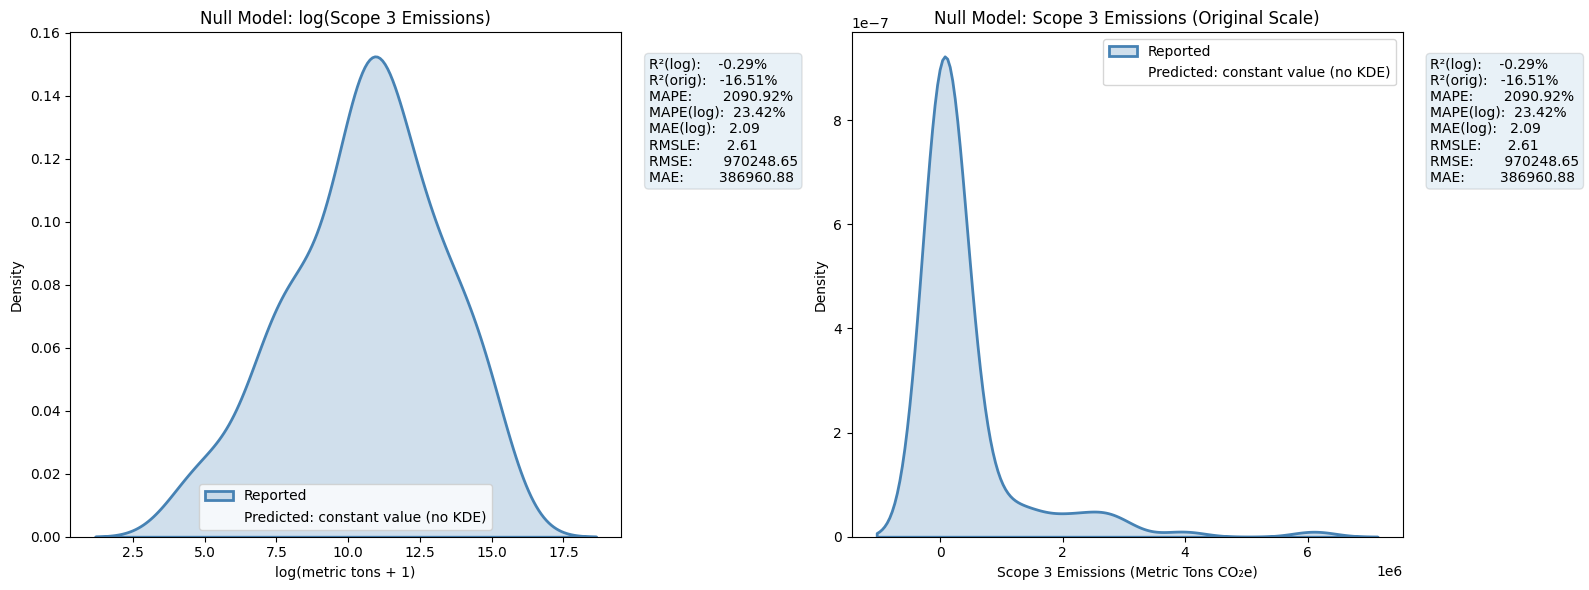

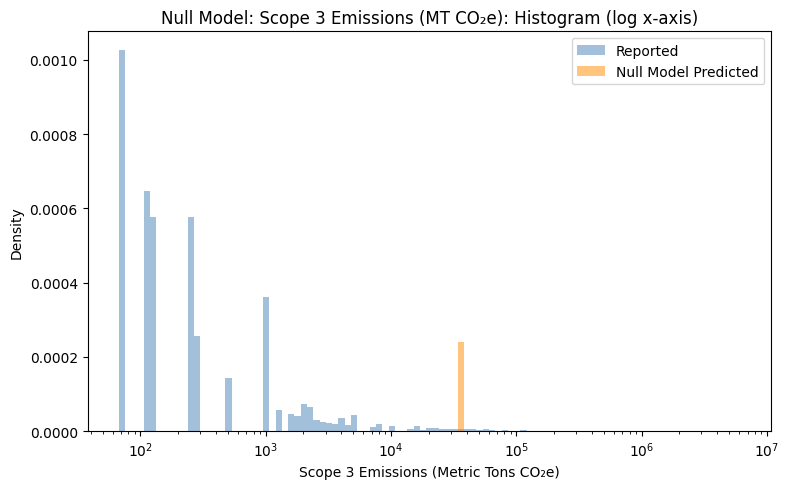

In [22]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE NULL MODEL (random intercept only) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    null_model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ 1",
        train_df,
        groups=train_df["account_id"]
    )
    null_result = null_model.fit(method="lbfgs")

if not null_result.converged:
    print("WARNING: Null model did not fully converge.")

print(null_result.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_null'] = null_result.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_null']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_null'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics text
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[0], color='gray')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Null Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[1], color='gray')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Null Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Null Model Predicted")
plt.xscale("log")
plt.title("Null Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
null_model_metrics = {
    "Model": "Null (RI)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "Random intercept only"
}

## Investments Two-Level Mixed-Effects Model

Two-level hierarchical linear mixed-effects model to predict log-transformed Scope 3 emissions at the company level. The model is fit to training data (from 2018–2022), and predictions are evaluated on a test set (from 2023).  This model provides a baseline for including time trends and company-level variability.
 
Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies.<br>
- Fixed Effects:
    - Year (numeric)
    - Year squared ('Year_sq', quadratic time trend)

Two-Level Model: Company/year group size summary:
count    192.000000
mean       2.979167
std        1.627507
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max        5.000000
dtype: float64
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 572     Method:             REML                        
No. Groups:       192     Scale:              0.9514                      
Min. group size:  1       Log-Likelihood:     -1097.6345                  
Max. group size:  5       Converged:          Yes                         
Mean group size:  3.0                                                     
---------------------------------------------------------------------------
               Coef.      Std.Err.     z     P>|z|     [0.025      0.975]  
---------------------------------------------------------------------------
Intercept   -108997.615  107309.883  -1.0

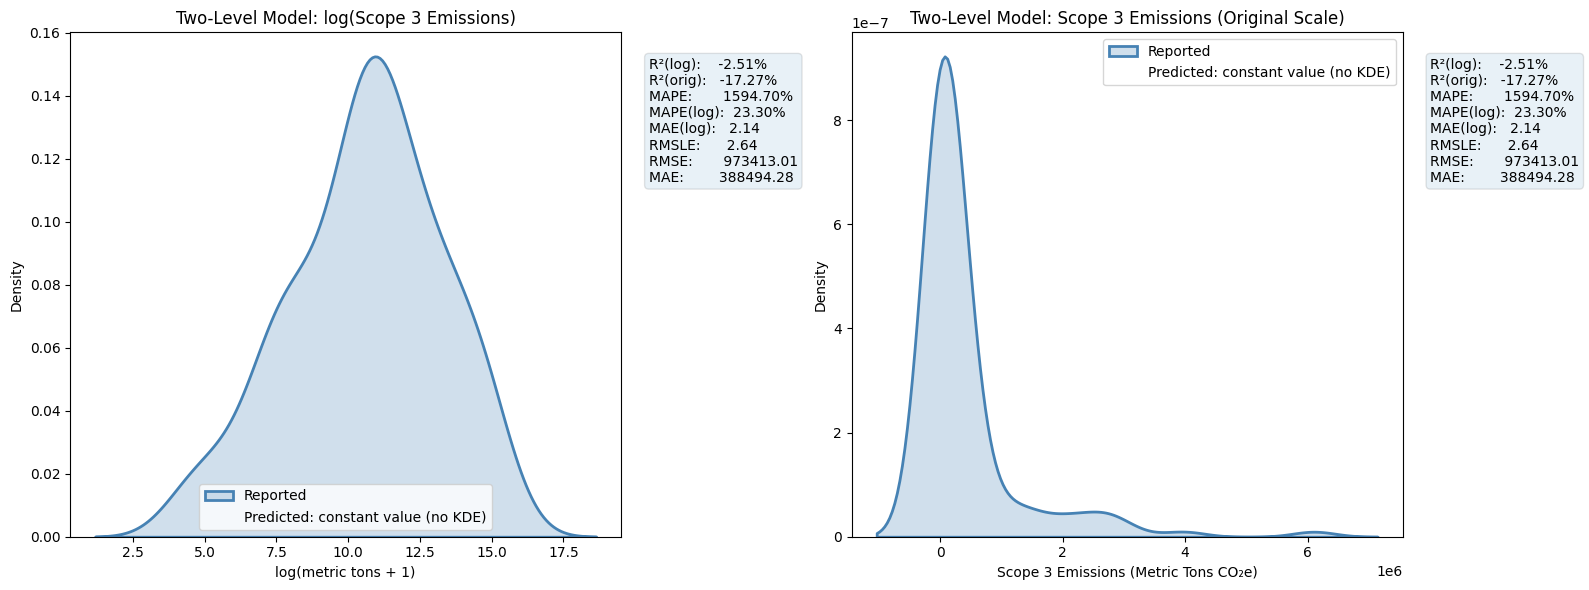

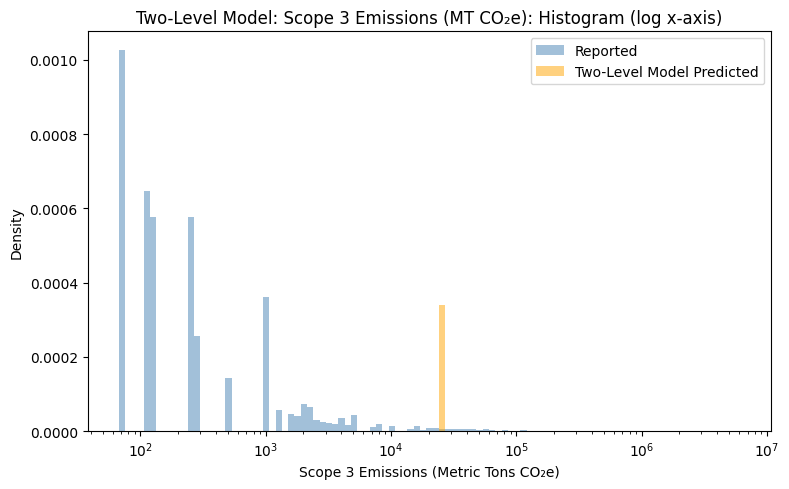

In [23]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- Check group sizes ---
group_sizes = train_df.groupby('account_id').size()
print("Two-Level Model: Company/year group size summary:")
print(group_sizes.describe())

# --- FIT THE TWO-LEVEL MODEL (random intercept, +Year, +Year_sq) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ Year + Year_sq",
        train_df,
        groups=train_df["account_id"],
        re_formula="1"
    )
    result_twolevel = model.fit(method="lbfgs")

if not result_twolevel.converged:
    print("WARNING: Two-level mixed model did not fully converge.")

print(result_twolevel.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_twolevel.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_mixed']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='orange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Two-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='orange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Two-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="orange", alpha=0.5, label="Two-Level Model Predicted")
plt.xscale("log")
plt.title("Two-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
two_level_model_metrics = {
    "Model": "2-level (RI+S)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "+Year, Year_sq"
}

## Investments Three-Level Mixed-Effects Model

A three-level hierarchical linear mixed-effects model is used to predict log-transformed Scope 3 emissions. It takes into account differences between primary activity, differences between companies, and changes over time. The model is trained using data from 2018 to 2022, and then tested on new data from 2023. This model provides insight on how emissions are influenced by primary activity, by individual companies, by financial and emissions factors, and by trends over time.

Model Structure:

- Level 3 (Primary Activity):<br>
    - Random intercept and random slope for Year for each primary activity ('Primary_activity'), capturing baseline primary activity and primary activity-specific time trends.<br>
- Level 2 (Account/Company):
    - Random intercept for each company ('account_id'), capturing company-level deviations within each primary activity.
- Level 1 (Yearly Observations):
    - Repeated annual observations within each company.

- Fixed Effects:
    - Signed log-transformed market cap ('slog_Market_Cap_USD')
    - Signed log-transformed revenue ('slog_Revenue_USD')
    - Signed log-transformed EBITDA ('slog_ebitda_USD') due to possible collinearity
    - Signed log-transformed Scope 1 & 2 emissions ('slog_scope_1_2_emissions_amount')

                     Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  log_Scope_3_emissions_amount
No. Observations:    572      Method:              REML                        
No. Groups:          63       Scale:               0.8256                      
Min. group size:     3        Log-Likelihood:      -1076.3319                  
Max. group size:     34       Converged:           Yes                         
Mean group size:     9.1                                                       
-------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            -2.551    3.380 -0.755 0.450 -9.176  4.073
slog_Market_Cap_USD                   0.001    0.117  0.009 0.993 -0.228  0.230
slog_Revenue_USD                      0.459    0.169  2.710 0

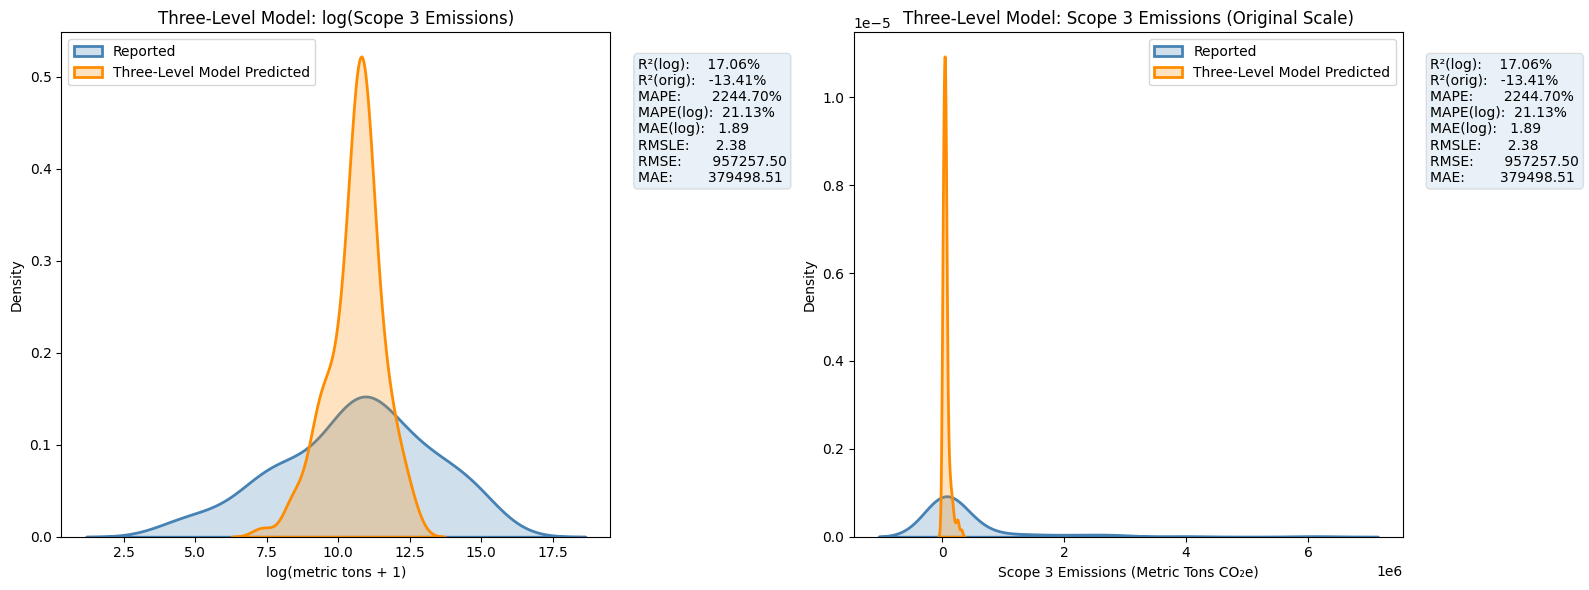

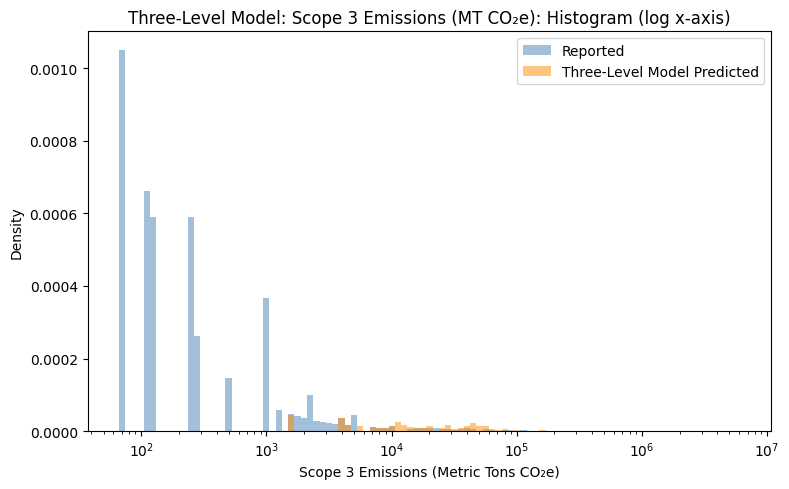

In [24]:
# --- Ensure grouping/categorical variables are string ---
for col in ['Countries', 'account_id', 'Primary_activity', 'Primary_sector']:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# --- Center the Year variable ---
year_mean = train_df['Year'].mean()
train_df['Year_centered'] = train_df['Year'] - year_mean
test_df['Year_centered'] = test_df['Year'] - year_mean

# --- Ensure log-transformed target exists ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE 3-LEVEL MIXED MODEL with Primary_activity as Level 3 group ---
vc = {'account_id': '0 + C(account_id)'}  # Level 2: account_id random intercept

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model_3level = MixedLM.from_formula(
        'log_Scope_3_emissions_amount ~ slog_Market_Cap_USD + slog_Revenue_USD + slog_ebitda_USD + slog_scope_1_2_emissions_amount',
        groups='Primary_activity',
        re_formula='~Year_centered',
        vc_formula=vc,
        data=train_df
    )
    result_3level = model_3level.fit(method="lbfgs", maxiter=1000)

if not result_3level.converged:
    print("WARNING: Three-level mixed model did not fully converge.")

print(result_3level.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_3level.predict(test_df)

# --- Compute back-transformed values ---
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])

# --- Robust Mask for finite values everywhere ---
mask = (
    np.isfinite(test_df['log_Scope_3_emissions_amount']) &
    np.isfinite(test_df['predicted_mixed']) &
    np.isfinite(test_df['Reported_Scope_3']) &
    np.isfinite(test_df['Predicted_Scope_3'])
)
test_df = test_df.loc[mask].copy()

y_true_log = test_df['log_Scope_3_emissions_amount'].values
y_pred_log = test_df['predicted_mixed'].values
y_true = test_df['Reported_Scope_3'].values
y_pred = test_df['Predicted_Scope_3'].values

# Final defensive check and diagnostics
arrays = {
    "y_true_log": y_true_log,
    "y_pred_log": y_pred_log,
    "y_true": y_true,
    "y_pred": y_pred,
}
for arr_name, arr in arrays.items():
    if not np.all(np.isfinite(arr)):
        print(f"ERROR: {arr_name} contains non-finite values!")
        print(f"Non-finite indices: {np.where(~np.isfinite(arr))[0]}")
        print(f"Values: {arr[~np.isfinite(arr)]}")
        raise ValueError(f"{arr_name} contains infs or NaNs after masking!")

# --- METRICS ---
mae_log = mean_absolute_error(y_true_log, y_pred_log)
nonzero_mask = y_true_log != 0
if np.any(nonzero_mask):
    mape_log = np.mean(np.abs((y_true_log[nonzero_mask] - y_pred_log[nonzero_mask]) / y_true_log[nonzero_mask])) * 100
else:
    mape_log = np.nan

r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)

metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
if len(np.unique(y_pred_log)) > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Three-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

if len(np.unique(y_pred)) > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Three-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Filter strictly positive values for histogram (log x-axis requires >0)
y_true_pos = y_true[y_true > 0]
y_pred_pos = y_pred[y_pred > 0]

if y_true_pos.size > 0 and y_pred_pos.size > 0:
    min_val = min(y_true_pos.min(), y_pred_pos.min())
    max_val = max(y_true_pos.max(), y_pred_pos.max())
    if min_val == max_val:
        print("Skipping histogram: Only one unique positive value present.")
    else:
        log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

        plt.figure(figsize=(8, 5))
        sns.histplot(y_true_pos, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
        sns.histplot(y_pred_pos, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Three-Level Model Predicted")
        plt.xscale("log")
        plt.title("Three-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
        plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Skipping histogram: Not enough positive values in y_true or y_pred for log-scale histogram.")

# --- RETURN METRICS FOR SUMMARY TABLE ---
three_level_model_metrics = {
    "Model": "3-level (Primary Activity/Account/Year)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,
    "MAPE(log)": mape_log,
}

## Investments Full Mixed-Effects Model

A full mixed-effects model is used to predict company Scope 3 emissions, using financial and emissions data, along with information about country, industry, and year. The model is trained on data from 2018 to 2022, and tested on data from 2023. This full model helps provides insights into how a company’s finances, emissions, primary activity, country and the year influence emissions.<br>

Model Structure:<br>

- Random Effects:<br>
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:<br>
    - Signed log-transformed financial and emissions features:<br>
        - Market Cap ('slog_Market_Cap_USD')<br>
        - Revenue ('slog_Revenue_USD')<br>
        - EBITDA ('slog_ebitda_USD')<br>
        - Gross Profit ('slog_grossProfit_USD')<br>
        - Total Assets ('slog_totalAssets_USD')<br>
        - Total Equity ('slog_totalEquity_USD')<br>
        - Scope 1&2 Emissions ('slog_scope_1_2_emissions_amount')<br>
    - Country ('Countries', as a categorical variable)<br>
    - Primary Activity ('Primary_activity', as a categorical variable)<br>
    - Year (numeric)<br>

                                        Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                572                   Method:                           ML                           
No. Groups:                      192                   Scale:                            0.9507                       
Min. group size:                 1                     Log-Likelihood:                   -1005.8360                   
Max. group size:                 5                     Converged:                        Yes                          
Mean group size:                 3.0                                                                                  
----------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.

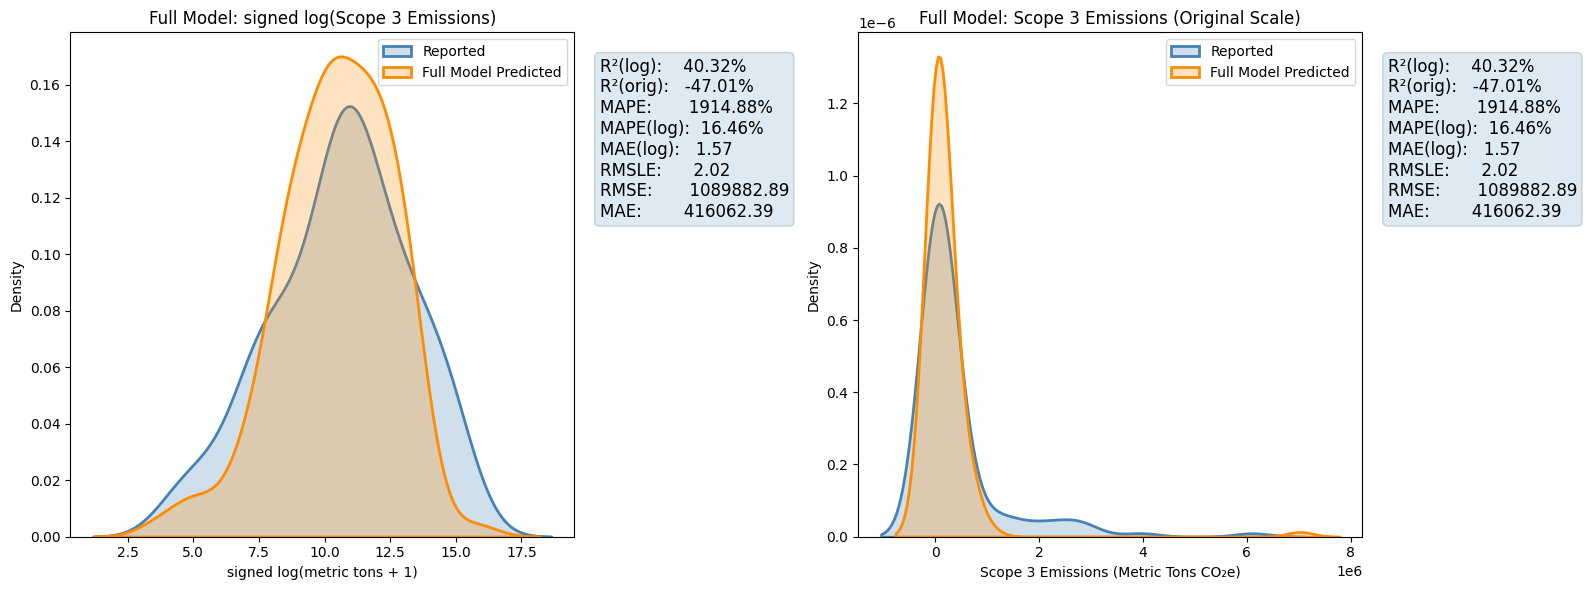

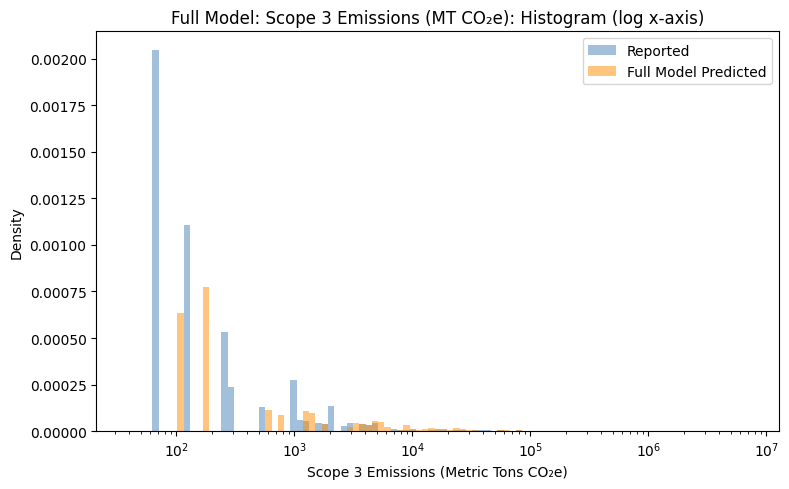

In [25]:
# --- Feature and target columns ---
numeric_cols = ['Market_Cap_USD',
 'Revenue_USD',
 'ebitda_USD',
 'grossProfit_USD',
 'totalAssets_USD',
 'totalEquity_USD',
 'Scope_3_emissions_amount',
 'scope_1_2_emissions_amount'
]
feature_cols_slog = [f'slog_{col}' for col in numeric_cols if col != 'Scope_3_emissions_amount']
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
required_cols = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_full = train_df.dropna(subset=required_cols).copy()
test_df_full = test_df.dropna(subset=required_cols).copy()

if test_df_full.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the full mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_full, groups=train_df_full['account_id'])
        mdf = md.fit(reml=False)
    print(mdf.summary())

    # --- Predict on test set ---
    test_df_full['predicted_log'] = mdf.predict(test_df_full)
    test_df_full['predicted'] = np.sign(test_df_full['predicted_log']) * (np.expm1(np.abs(test_df_full['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_full[target_col_slog]
    y_pred_log = test_df_full['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_full['predicted']

    # Mask for finite values
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nFull Mixed-Effects Model (Full Model) Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf.params,
        'pvalue': mdf.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Full Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Full Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Full Model Predicted")
    plt.xscale("log")
    plt.title("Full Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    full_model_metrics = {
        "Model": "Full Model",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

## Investments Optimized Mixed-Effects Model

An optimized mixed-effects model is used to predict company Scope 3 emissions. The model provides accurate prediction using only the most significant predictive features, while still accounting for primary activity, country and company level effects. The model is trained on data from 2018–2022 and evaluated on test data from 2023.

Model Structure:

- Random Effects:
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:
    - Signed log-transformed features:
        - Revenue ('slog_Revenue_USD')
        - Total Assets ('slog_totalAssets_USD')
        - Scope 1 & 2 Emissions ('slog_scope_1_2_emissions_amount')
    - Country ('Countries', as a categorical variable)
    - Primary Activity ('Primary_activity', as a categorical variable)

                                        Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:               572                   Method:                           ML                           
No. Groups:                     192                   Scale:                            0.9641                       
Min. group size:                1                     Log-Likelihood:                   -1009.2618                   
Max. group size:                5                     Converged:                        Yes                          
Mean group size:                3.0                                                                                  
---------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z   

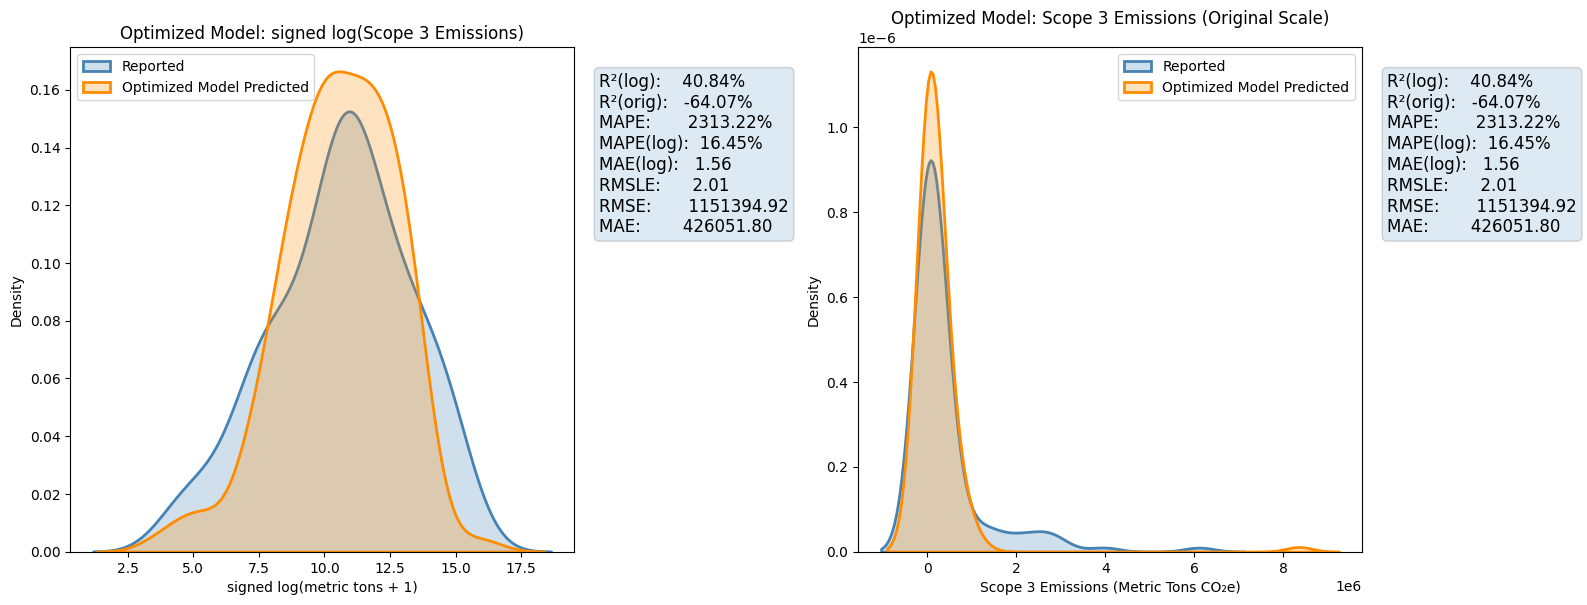

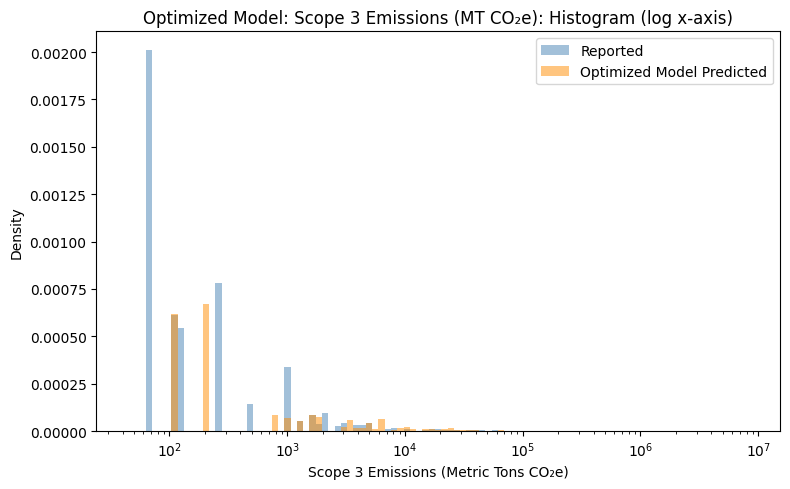

In [26]:
feature_cols_slog = [
    'slog_Revenue_USD',
    'slog_totalAssets_USD',
    'slog_scope_1_2_emissions_amount'
]
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
all_model_vars = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_opt = train_df.dropna(subset=all_model_vars).copy()
test_df_opt = test_df.dropna(subset=all_model_vars).copy()

if test_df_opt.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity)'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the optimized mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_opt, groups=train_df_opt['account_id'])
        mdf_optimized = md.fit(reml=False)
    print(mdf_optimized.summary())

    # --- Predict on test set ---
    test_df_opt['predicted_log'] = mdf_optimized.predict(test_df_opt)
    test_df_opt['predicted'] = np.sign(test_df_opt['predicted_log']) * (np.expm1(np.abs(test_df_opt['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_opt[target_col_slog]
    y_pred_log = test_df_opt['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_opt['predicted']

    # Mask for valid/finites
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <-- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nOptimized Mixed-Effects Model: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_optimized.params,
        'pvalue': mdf_optimized.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Optimized Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Optimized Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Optimized Model Predicted")
    plt.xscale("log")
    plt.title("Optimized Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    optimized_model_metrics = {
        "Model": "Optimized",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

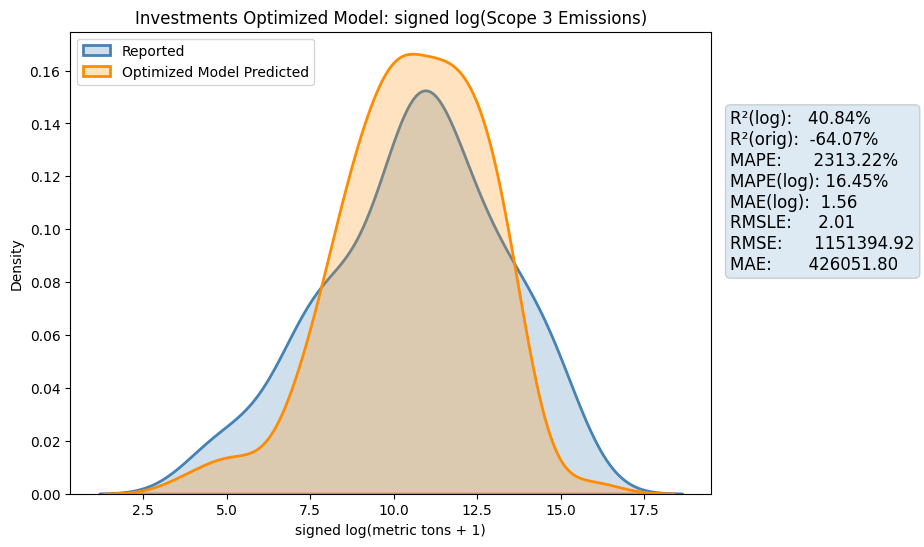

In [27]:
metrics_text_log = (
    f"R²(log):   {r2_log_pct:.2f}%\n"
    f"R²(orig):  {r2_pct:.2f}%\n"
    f"MAPE:      {mape_orig:.2f}%\n"
    f"MAPE(log): {mape_log:.2f}%\n"
    f"MAE(log):  {mae_log:.2f}\n"
    f"RMSLE:     {rmsle:.2f}\n"
    f"RMSE:      {rmse_orig:.2f}\n"
    f"MAE:       {mae_orig:.2f}"
)

fig, ax = plt.subplots(figsize=(9.5, 6))  # Wider to make room for the box

if hasattr(y_pred_log, "nunique"):
    multiple_vals = y_pred_log.nunique() > 1
else:
    multiple_vals = len(set(y_pred_log)) > 1

if multiple_vals:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=ax, color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    ax.plot([], [], ' ', label="Predicted: constant value (no KDE)")

ax.set_title("Investments Optimized Model: signed log(Scope 3 Emissions)")
ax.set_xlabel("signed log(metric tons + 1)")
ax.set_ylabel("Density")
ax.legend()

# Place metrics box outside plot to the right
fig.text(
    0.82, 0.75, metrics_text_log,
    va='top', ha='left',
    fontsize=12, bbox=dict(boxstyle='round', alpha=0.15)
)

plt.subplots_adjust(right=0.8)  # Make sure there's room for the box
fig.savefig("investments_scope3_log_density.png", dpi=300, bbox_inches='tight')
plt.show()

# Metrics Table for Investments

In [28]:
metrics_dicts = [
    null_model_metrics,
    two_level_model_metrics,
    three_level_model_metrics,
    full_model_metrics,
    optimized_model_metrics
]

for metrics, train, test in zip(
        metrics_dicts,
        [train_df, train_df, train_df, train_df, train_df],
        [test_df, test_df, test_df, test_df, test_df]):
    
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"

metrics_df = pd.DataFrame(metrics_dicts)

# Ensure all relevant columns are ordered and present
desired_order = [
    "Model", "R2_log", "R2_orig", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)"
]


# Ensure MAE_log is present, fill with NaN if missing
if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

metrics_df_display = metrics_df.copy()
if "R2_log" in metrics_df_display.columns:
    metrics_df_display["R2_log"] = (metrics_df_display["R2_log"] * 100).map("{:.2f}%".format)
if "R2_orig" in metrics_df_display.columns:
    metrics_df_display["R2_orig"] = (metrics_df_display["R2_orig"] * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "MAPE(log)"]:
    if col in metrics_df_display.columns:
        metrics_df_display[col] = metrics_df_display[col].map("{:.2f}".format)

from IPython.display import display
display(metrics_df_display)

,Model,R2_log,R2_orig,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test)
0,Null (RI),-0.29%,-16.51%,970248.65,386960.88,2.09,2.61,2090.92,572/120
1,2-level (RI+S),-2.51%,-17.27%,973413.01,388494.28,2.14,2.64,1594.70,572/120
2,3-level (Primary Activity/Account/Year),17.06%,-13.41%,957257.50,379498.51,1.89,2.38,2244.70,572/120
3,Full Model,40.32%,-47.01%,1089882.89,416062.39,1.57,2.02,1914.88,572/120
4,Optimized,40.84%,-64.07%,1151394.92,426051.80,1.56,2.01,2313.22,572/120
